In [4]:
# 회귀모형 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

# 쓸데없는 알림 방지
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

#통계적 모형
import statsmodels.api as sm # 선형회귀 
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공산성 

#머신러닝
from sklearn import datasets
from sklearn import metrics
from sklearn import svm, neighbors, tree  # 트리 KNN 

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier # 앙상블  
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression #릿지라쏘 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold # 그리드 서치, 트레인 테스트 셋 분리 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer,MinMaxScaler # scale

from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error #연속형일때 사용하는 경우 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix #범주형(분류모델)

# boost 계열 
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

In [5]:
titanic_raw_data = pd.read_csv('C:/Users/scien/Videos/titanic/titanic_full_data.csv')

In [6]:
titanic_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1285 non-null   int64  
 1   Survived     1285 non-null   int64  
 2   Pclass       1285 non-null   int64  
 3   Name         1285 non-null   object 
 4   Sex          1285 non-null   object 
 5   Age          1030 non-null   float64
 6   SibSp        1285 non-null   int64  
 7   Parch        1285 non-null   int64  
 8   Ticket       1285 non-null   object 
 9   Fare         1284 non-null   float64
 10  Cabin        294 non-null    object 
 11  Embarked     1283 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 120.6+ KB


### 결측치, 문자열 데이터를 어떻게 전처리 해야하는가? 

- PassengerId (index)
- Name (지워버림)
- sex (원핫 인코딩으로 수치화)
- Ticket (지움)
- Cabin (빼줘)
- Embark (원핫 인코딩으로 수치화)

In [7]:
# 반응변수 Y를 만들자 
titanic_target = titanic_raw_data['Survived']

In [8]:
titanic_target

0       0
1       1
2       1
3       1
4       0
       ..
1280    0
1281    1
1282    0
1283    0
1284    1
Name: Survived, Length: 1285, dtype: int64

In [9]:
# Y 해당하는 survived 제외, 문자열 타입 Name, Cabin 제외 
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked']

In [10]:
# 입력변수 X를 만들자 
titanic_features = titanic_raw_data[columns]
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
1280,3,male,NaN,0,0,8.0500,S
1281,1,female,39.0,0,0,108.9000,C
1282,3,male,38.5,0,0,7.2500,S
1283,3,male,NaN,0,0,8.0500,S


In [11]:
# 문자열 자료를 이산형으로 만들기 
# 굳이 2개 다 쓸 필요가 없어 하나만 이용할 것임 drop_first = True
# 만일 female을 남기고 싶다면?
# columns=['male', 'female']

titanic_features[['feamle', 'male']] = pd.get_dummies(titanic_features['Sex'])

In [12]:
titanic_features.drop(columns=['Sex'], inplace=True)

In [13]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,Embarked,feamle,male
0,3,22.0,1,0,7.2500,S,0,1
1,1,38.0,1,0,71.2833,C,1,0
2,3,26.0,0,0,7.9250,S,1,0
3,1,35.0,1,0,53.1000,S,1,0
4,3,35.0,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...
1280,3,NaN,0,0,8.0500,S,0,1
1281,1,39.0,0,0,108.9000,C,1,0
1282,3,38.5,0,0,7.2500,S,0,1
1283,3,NaN,0,0,8.0500,S,0,1


In [14]:
titanic_features['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [15]:
dummy_columns = pd.get_dummies(titanic_features['Embarked'], prefix='Embarked').columns

In [16]:
titanic_features[dummy_columns] = pd.get_dummies(titanic_features['Embarked'], prefix='Embarked')

In [17]:
titanic_features.drop(columns=['Embarked'], inplace=True)

In [18]:
# pd.cut(data, bins, label) n개의 구간별로 나누기 pd.cut

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80] # 시작과 끝값을 지정
labels = ['child', 'teens', '20s', '30s', '40s', '50s', '60s', '70s']

pd.cut(titanic_features['Age'], bins=bins, labels=labels).value_counts()

# 결측치 삭제 필요 

20s      357
30s      209
teens    156
40s      128
child     85
50s       62
60s       27
70s        6
Name: Age, dtype: int64

In [19]:
# 나이의 결측치 
titanic_features.Age.isna().sum()

255

In [20]:
# 평균 30살 
round(titanic_features.Age.mean())

30

In [21]:
# 나이 결측치를 평균 나이로 채워주기 
titanic_features.Age.fillna(round(titanic_features.Age.mean()), inplace=True)

In [22]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1285 non-null   int64  
 1   Age         1285 non-null   float64
 2   SibSp       1285 non-null   int64  
 3   Parch       1285 non-null   int64  
 4   Fare        1284 non-null   float64
 5   feamle      1285 non-null   uint8  
 6   male        1285 non-null   uint8  
 7   Embarked_C  1285 non-null   uint8  
 8   Embarked_Q  1285 non-null   uint8  
 9   Embarked_S  1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 56.6 KB


In [24]:
# 3등실의 평균 Fare는?
titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean()

13.269605772005766

In [26]:
titanic_features.Fare.fillna(round(titanic_features.loc[titanic_features.Pclass == 3]['Fare'].mean(), 4), inplace=True)

In [27]:
# 모든 결측치를 채웠다 
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1285 non-null   int64  
 1   Age         1285 non-null   float64
 2   SibSp       1285 non-null   int64  
 3   Parch       1285 non-null   int64  
 4   Fare        1285 non-null   float64
 5   feamle      1285 non-null   uint8  
 6   male        1285 non-null   uint8  
 7   Embarked_C  1285 non-null   uint8  
 8   Embarked_Q  1285 non-null   uint8  
 9   Embarked_S  1285 non-null   uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 56.6 KB


In [28]:
titanic_features

,Pclass,Age,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1280,3,30.0,0,0,8.0500,0,1,0,0,1
1281,1,39.0,0,0,108.9000,1,0,1,0,0
1282,3,38.5,0,0,7.2500,0,1,0,0,1
1283,3,30.0,0,0,8.0500,0,1,0,0,1


In [29]:
print(titanic_features.isna().sum())
print(titanic_target.isna().sum())

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
feamle        0
male          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64
0


### 분리 전에 다중공산성 확인 
- 상관계수/산점도를 통한 다중공산성을 확인할 수 있는 방법 
- 

In [32]:
titanic_features.corr().style.background_gradient().set_precision(2)

,Pclass,Age,SibSp,Parch,Fare,feamle,male,Embarked_C,Embarked_Q,Embarked_S
Pclass,1.00,-0.37,0.06,0.01,-0.56,-0.14,0.14,-0.28,0.23,0.10
Age,-0.37,1.00,-0.19,-0.13,0.17,-0.06,0.06,0.08,-0.01,-0.07
SibSp,0.06,-0.19,1.00,0.38,0.16,0.11,-0.11,-0.05,-0.05,0.07
Parch,0.01,-0.13,0.38,1.00,0.23,0.21,-0.21,-0.01,-0.10,0.07
Fare,-0.56,0.17,0.16,0.23,1.00,0.19,-0.19,0.29,-0.13,-0.18
feamle,-0.14,-0.06,0.11,0.21,0.19,1.00,-1.00,0.07,0.08,-0.12
male,0.14,0.06,-0.11,-0.21,-0.19,-1.00,1.00,-0.07,-0.08,0.12
Embarked_C,-0.28,0.08,-0.05,-0.01,0.29,0.07,-0.07,1.00,-0.16,-0.78
Embarked_Q,0.23,-0.01,-0.05,-0.10,-0.13,0.08,-0.08,-0.16,1.00,-0.49
Embarked_S,0.10,-0.07,0.07,0.07,-0.18,-0.12,0.12,-0.78,-0.49,1.00


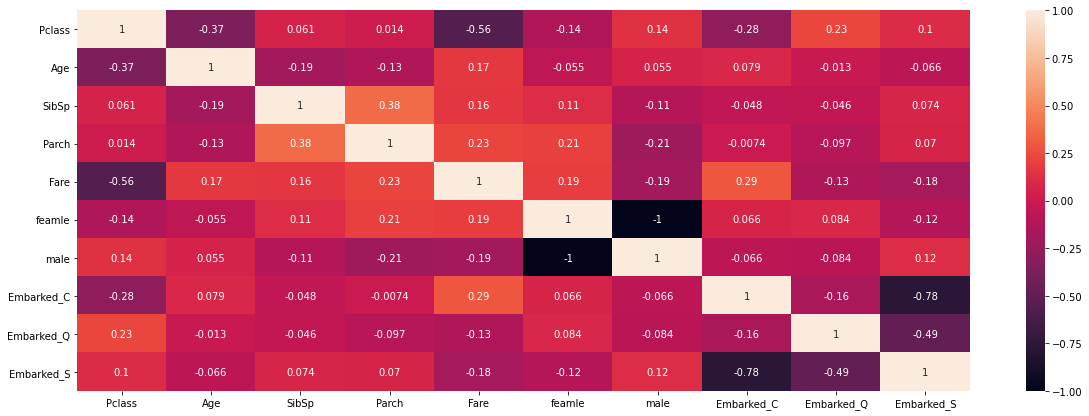

In [34]:
plt.figure(figsize=(20,7))
sns.heatmap(titanic_features.corr(), annot=True)
plt.show()

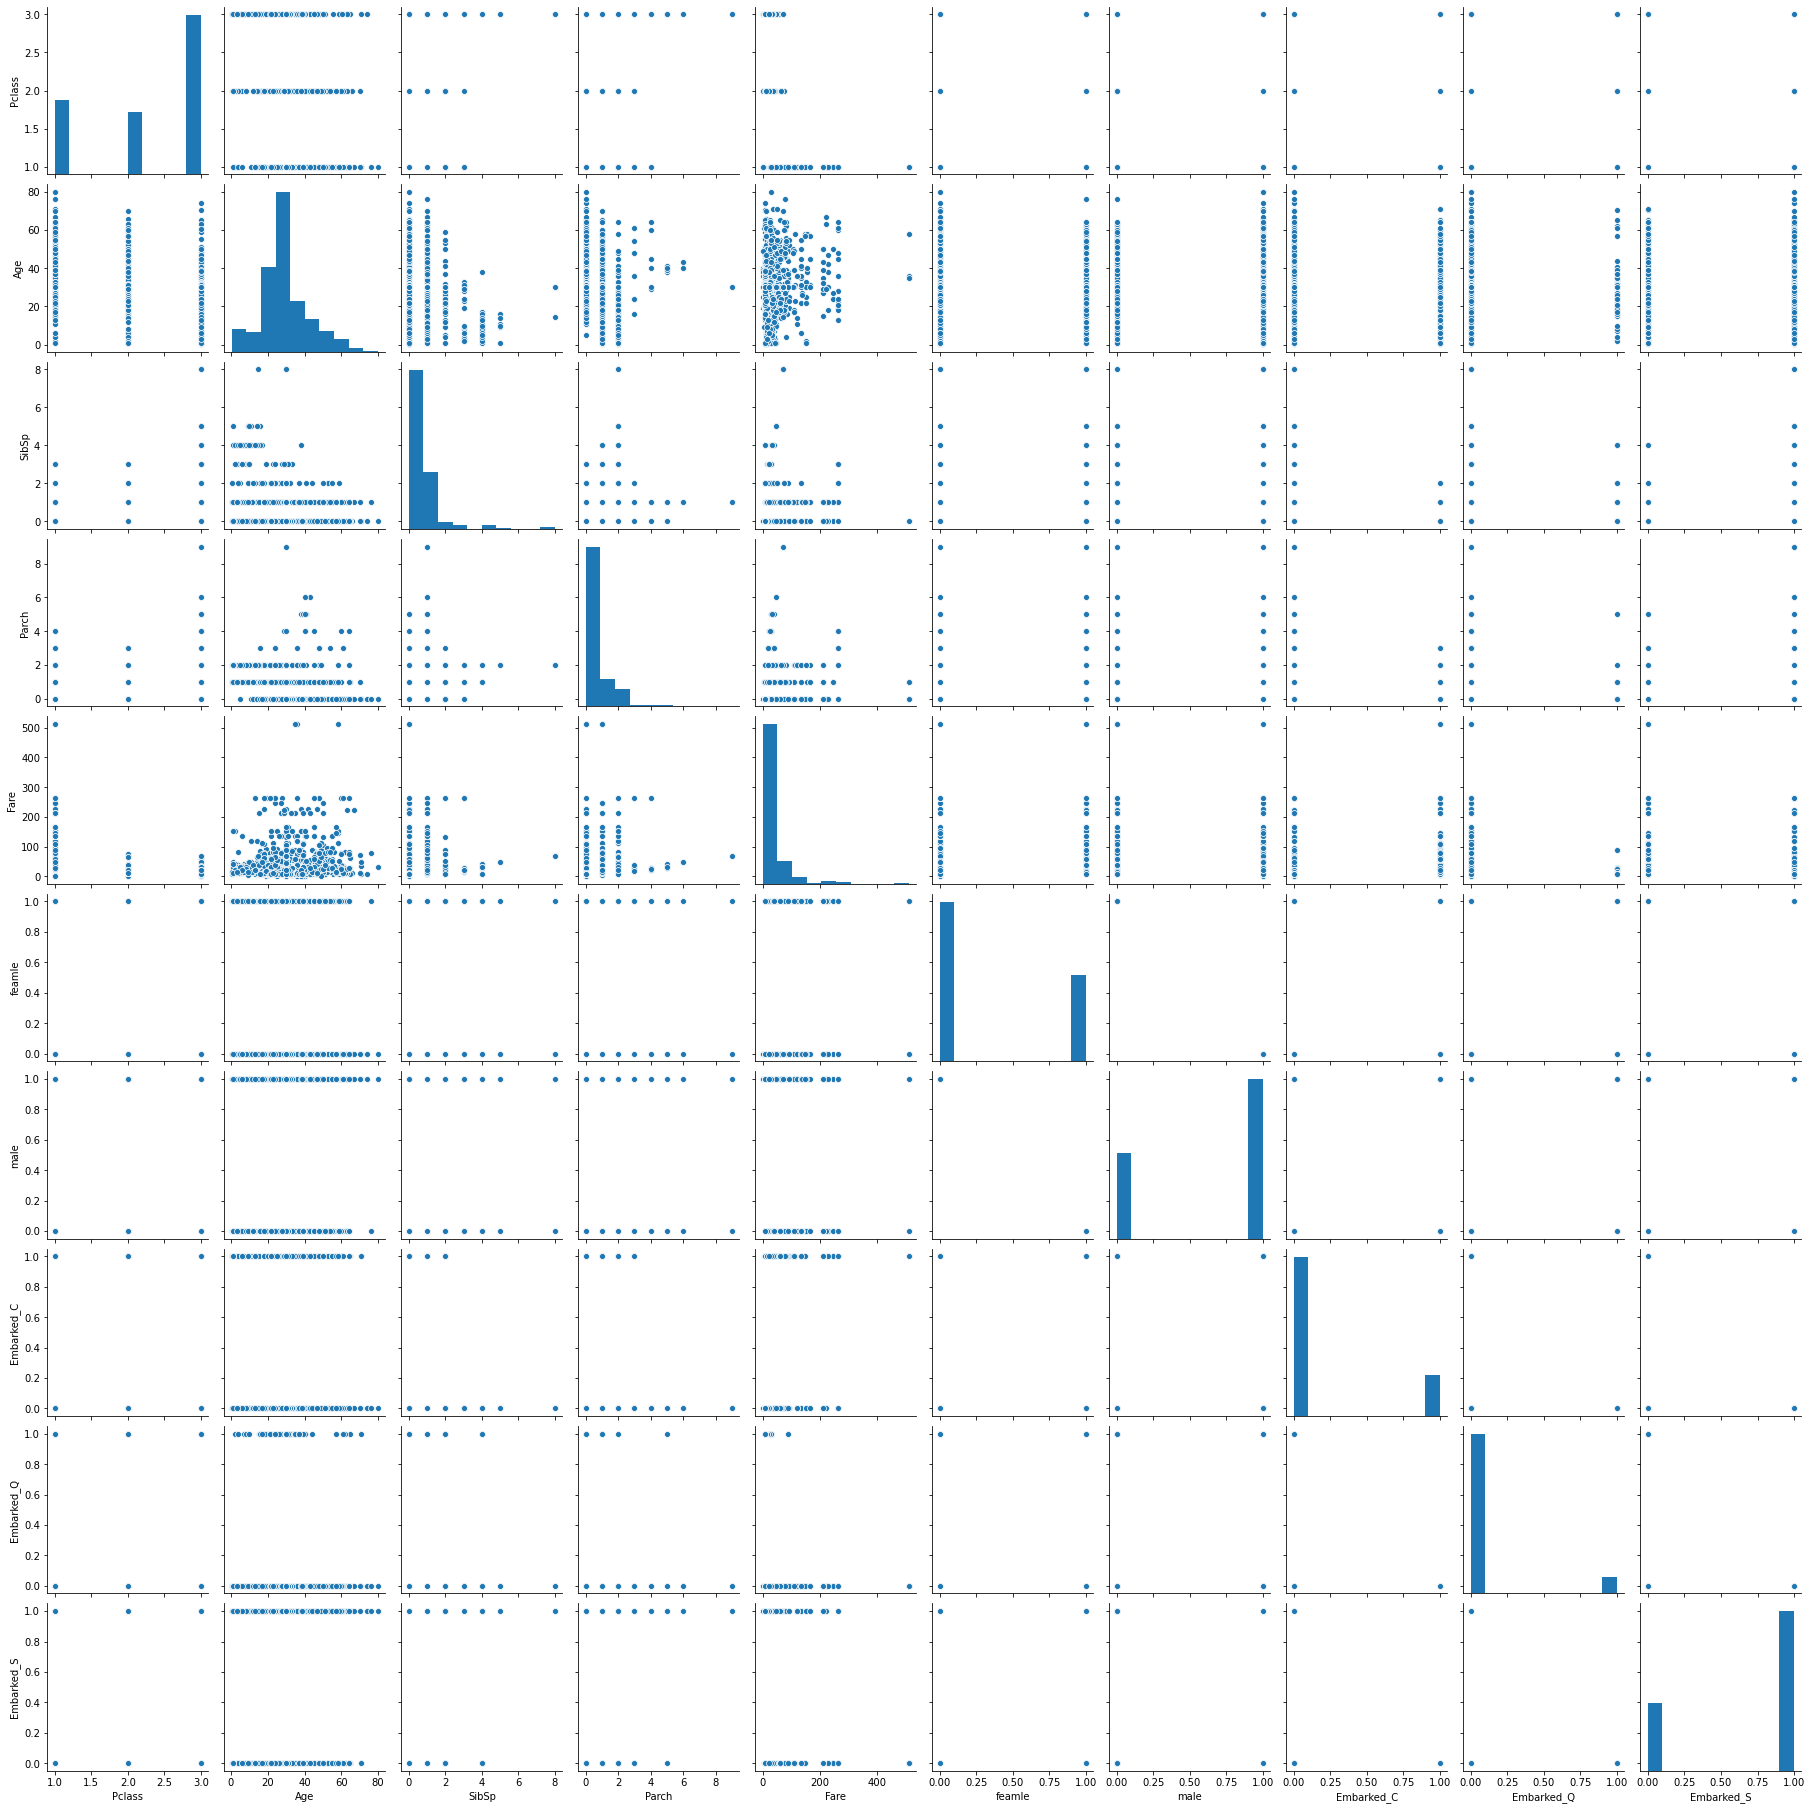

In [35]:
sns.pairplot(titanic_features)
plt.show()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(titanic_features, titanic_target, train_size=0.8, random_state = 123)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

### 모델을 적합하기 전에 스케일링이 필요하다. 

In [27]:
std_scaler = StandardScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
# x의 값을 스케일링 해주고, X와 Y좌표를 X의 데이터 그대로 적합시켜준다.


test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### min max sclaer (가장 많이 사용하는 스케일링)

In [28]:
std_scaler = MinMaxScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### RobustCaler 

In [29]:
std_scaler = RobustScaler()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)

### R에서 사용하던 노멀라이저 스케일링 

In [30]:
std_scaler = Normalizer()
std_scaler_fit = std_scaler.fit(train_x)
train_x_scale = pd.DataFrame(std_scaler_fit.transform(train_x), index=train_x.index, columns=train_x.columns)
test_x_scale = pd.DataFrame(std_scaler_fit.transform(test_x), index = test_x.index, columns=test_x.columns)